### Testing out the new project

In [ ]:
import sys
import os

sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np

from src.clean import detect_na, standardize_columns, impute_nas
from src.eda import extended_describe, plot_correlation_heatmap, plot_dists, calc_vif, lasso_feat_select
from src.train import train_model
from src.tune import grid_search
from src.eval import eval_classification
from src.predict import load_trained_model, make_preds

df = pd.read_csv('../data/Breast_Cancer.csv')

df

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4019,62,Other,Married,T1,N1,IIA,Moderately differentiated,2,Regional,9,Positive,Positive,1,1,49,Alive
4020,56,White,Divorced,T2,N2,IIIA,Moderately differentiated,2,Regional,46,Positive,Positive,14,8,69,Alive
4021,68,White,Married,T2,N1,IIB,Moderately differentiated,2,Regional,22,Positive,Negative,11,3,69,Alive
4022,58,Black,Divorced,T2,N1,IIB,Moderately differentiated,2,Regional,44,Positive,Positive,11,1,72,Alive


### Cleaning and Preprocessing

In [68]:
detect_na(df)

,Columns,NA_count
0,Age,0
1,Race,0
2,Marital Status,0
3,T Stage,0
4,N Stage,0
5,6th Stage,0
6,differentiate,0
7,Grade,0
8,A Stage,0
9,Tumor Size,0


### EDA

In [80]:
# This will kick off a much larger discussion about that OHE (One Hot Encoding) and the drop_first=True argument
# It's undeniable that some information will be lost, but it can be re-created, no? 
# Yes, they can! It's tedious, but it can be done... then what's the harm? 
# Well, when there's hundreds or thousands of features, categorical reconstruction doesn't feel as feasible! 
# Exploring this concept more in a blog post; for now we'll just use get_dummies as usual

df_encoded = pd.get_dummies(df, drop_first=True)

df_encoded = standardize_columns(df_encoded)
df_encoded

,age,tumor_size,regional_node_examined,reginol_node_positive,survival_months,race_other,race_white,marital_status_married,marital_status_separated,marital_status_single,...,differentiate_poorly_differentiated,differentiate_undifferentiated,differentiate_well_differentiated,grade_1,grade_2,grade_3,a_stage_regional,estrogen_status_positive,progesterone_status_positive,status_dead
0,68,4,24,1,60,False,True,True,False,False,...,True,False,False,False,False,True,True,True,True,False
1,50,35,14,5,62,False,True,True,False,False,...,False,False,False,False,True,False,True,True,True,False
2,58,63,14,7,75,False,True,False,False,False,...,False,False,False,False,True,False,True,True,True,False
3,58,18,2,1,84,False,True,True,False,False,...,True,False,False,False,False,True,True,True,True,False
4,47,41,3,1,50,False,True,True,False,False,...,True,False,False,False,False,True,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4019,62,9,1,1,49,True,False,True,False,False,...,False,False,False,False,True,False,True,True,True,False
4020,56,46,14,8,69,False,True,False,False,False,...,False,False,False,False,True,False,True,True,True,False
4021,68,22,11,3,69,False,True,True,False,False,...,False,False,False,False,True,False,True,True,False,False
4022,58,44,11,1,72,False,False,False,False,False,...,False,False,False,False,True,False,True,True,True,False


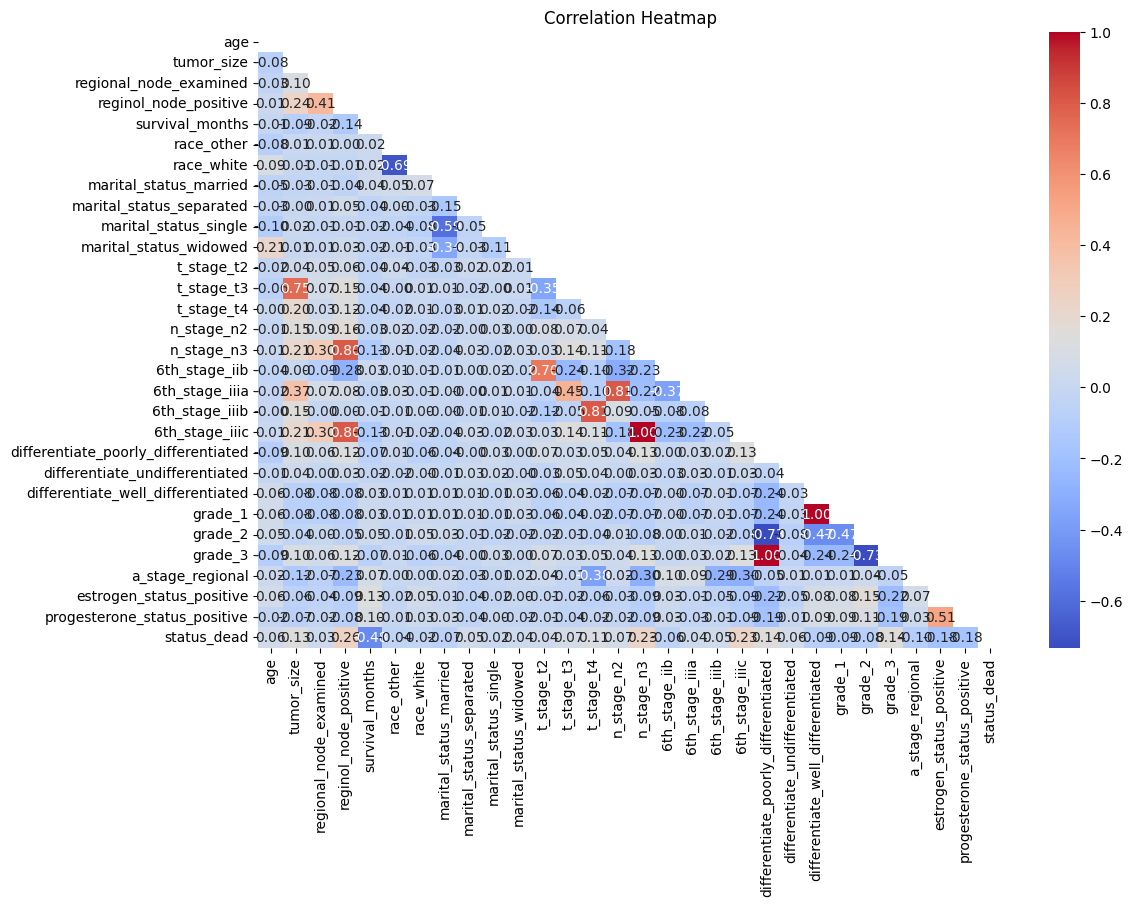

In [81]:
plot_correlation_heatmap(df_encoded)

Wow-- lots of features now, makes sense since we just performed OHE. However, there's way too much going on here, it needs to be cut down. I think for this task I'll use LASSO to perform automatic feature selection, with tumor_size as my target.

In [94]:
# Using tumor_size as target

lasso_feat_select(df_encoded, 'tumor_size')

Current features: 4
Original features: 30


,age,regional_node_examined,reginol_node_positive,survival_months,tumor_size
0,68,24,1,60,4
1,50,14,5,62,35
2,58,14,7,75,63
3,58,2,1,84,18
4,47,3,1,50,41
...,...,...,...,...,...
4019,62,1,1,49,9
4020,56,14,8,69,46
4021,68,11,3,69,22
4022,58,11,1,72,44


In [93]:
summary_stats = extended_describe(df) 
summary_stats

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
age,4024.0,53.972167,8.963134,30.0,47.0,54.0,61.0,69.0,-0.220373,-0.755088
tumor_size,4024.0,30.473658,21.119696,1.0,16.0,25.0,38.0,140.0,1.739750,3.634207
regional_node_examined,4024.0,14.357107,8.099675,1.0,9.0,14.0,19.0,61.0,0.829274,1.649322
reginol_node_positive,4024.0,4.158052,5.109331,1.0,1.0,2.0,5.0,46.0,2.702536,8.981266
survival_months,4024.0,71.297962,22.921430,1.0,56.0,73.0,90.0,107.0,-0.589998,0.019977


In [28]:
calc_vif(df)

,Feature,VIF
0,age,11.165060
1,tumor_size,3.076264
2,regional_node_examined,4.741349
3,reginol_node_positive,2.139799
4,survival_months,8.732301


Ah, seems like we've got some highly inflated features, namely `age` and `survival_months`! This calls for some investigation

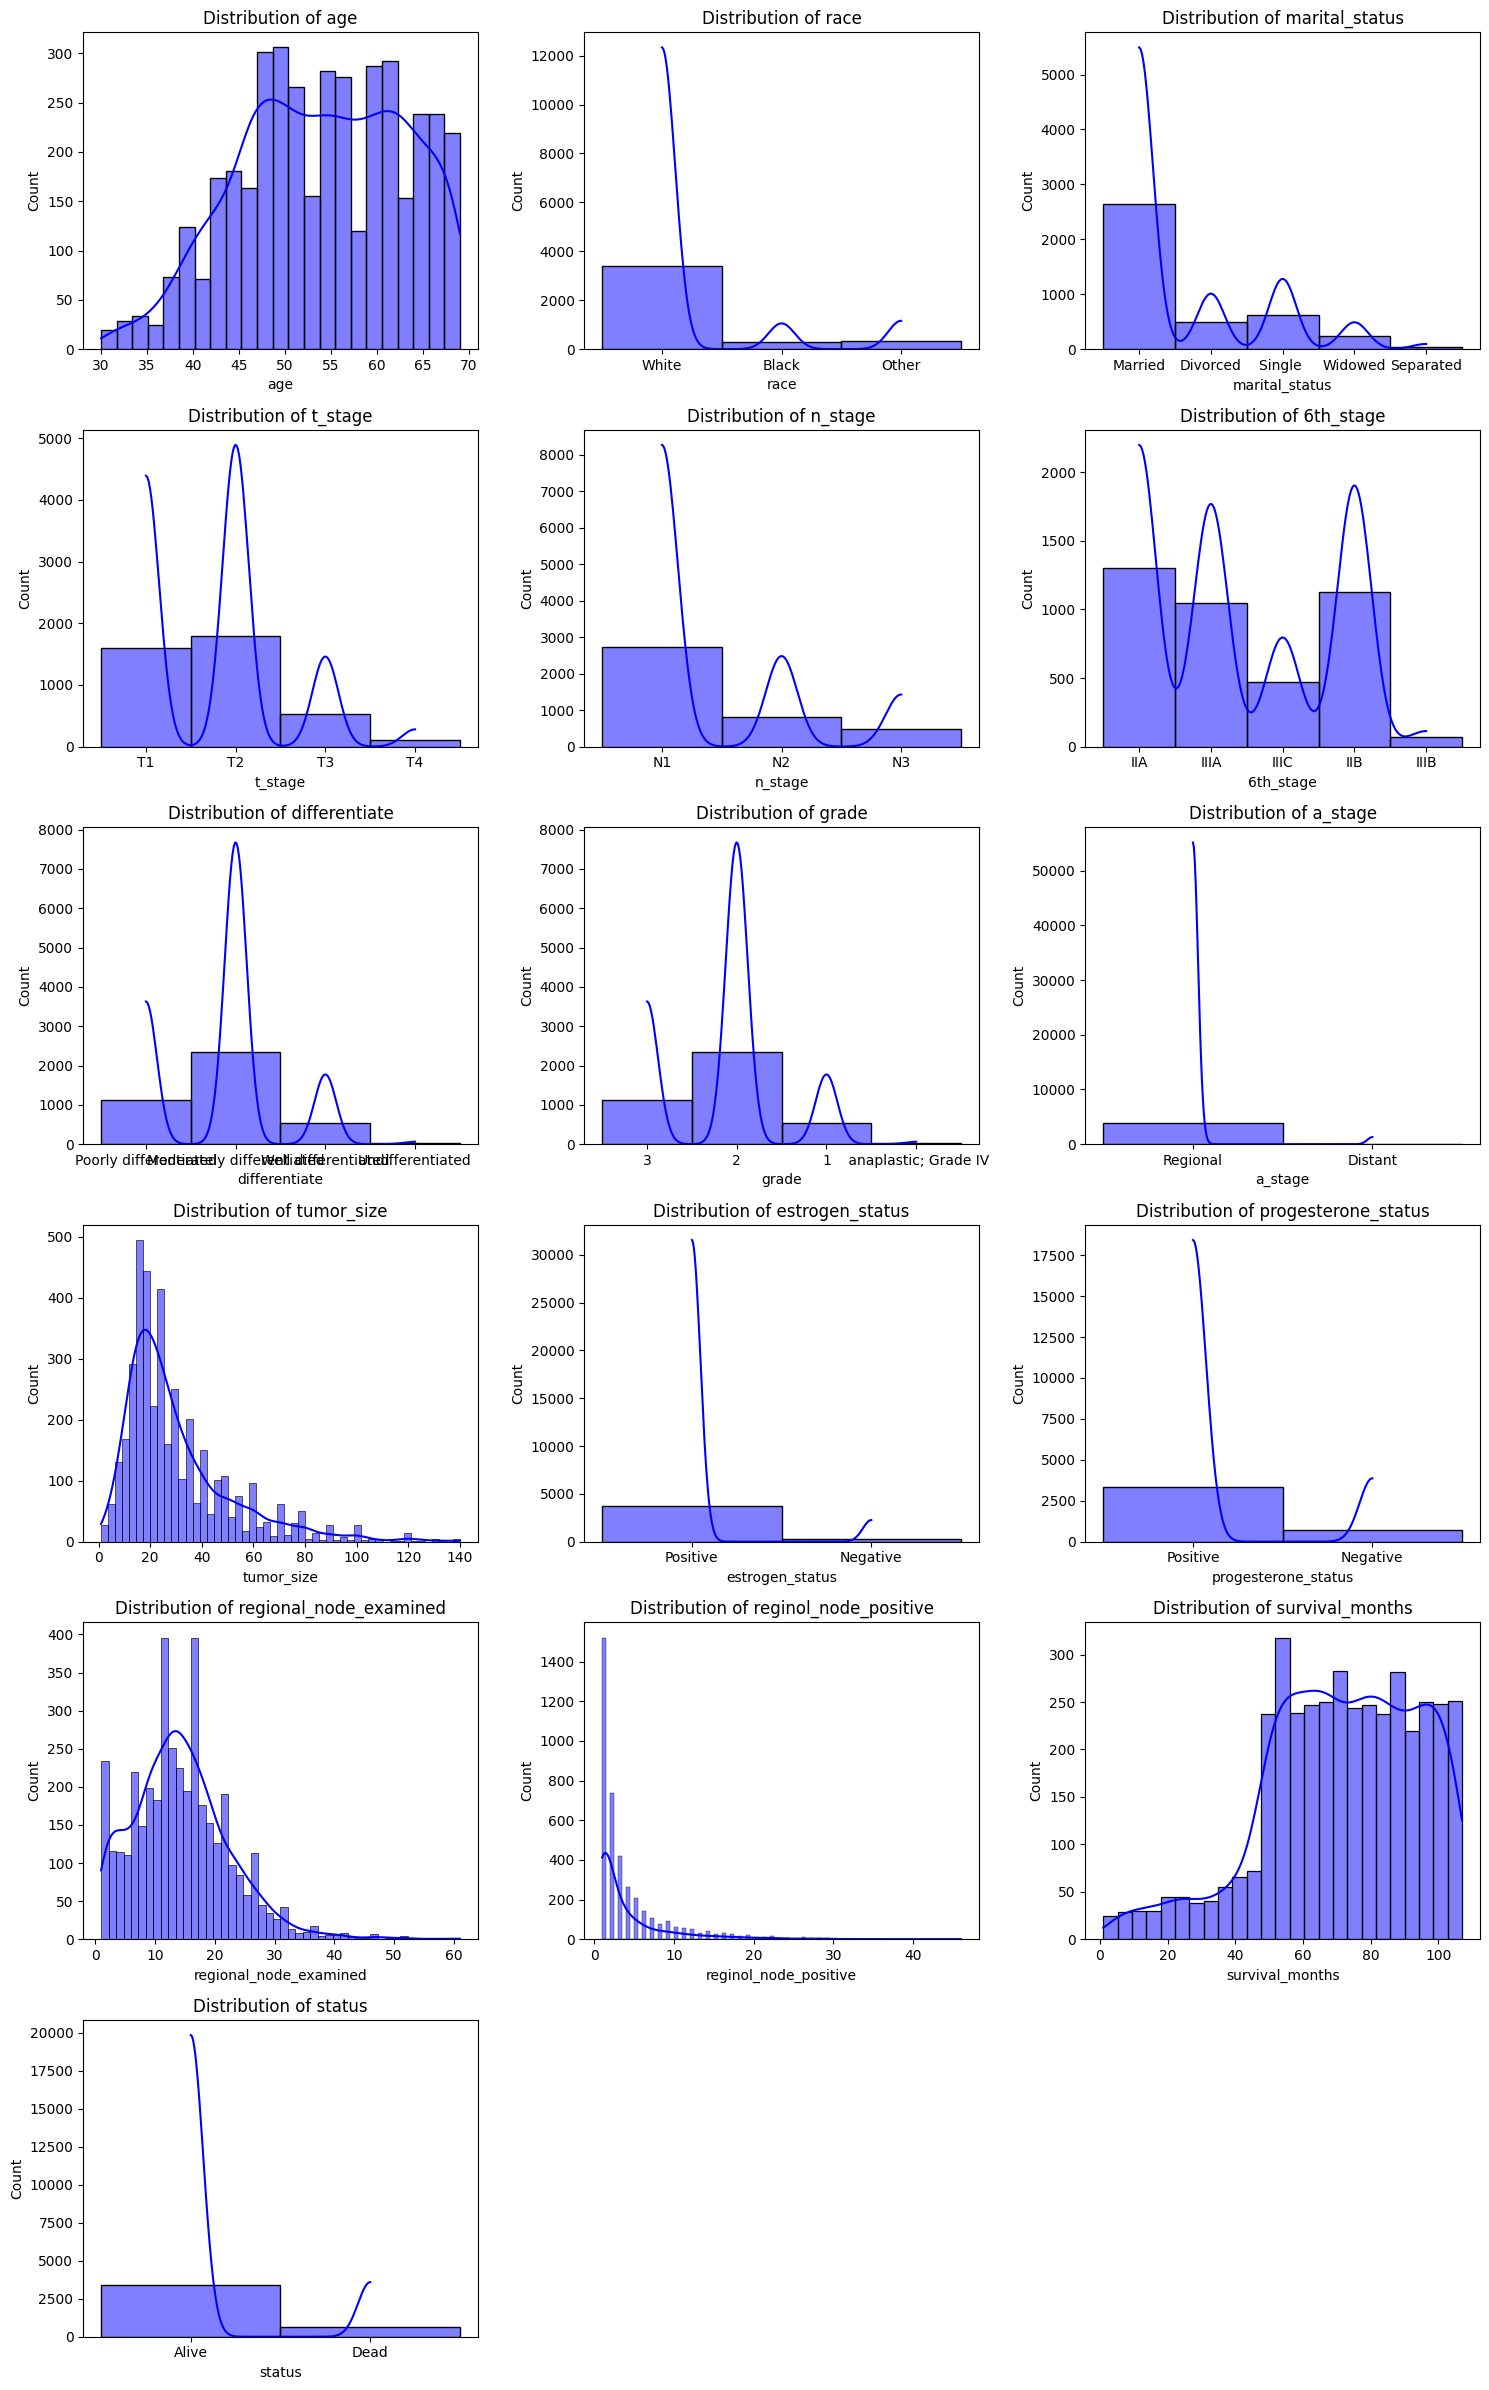

In [29]:
plot_dists(df, df.columns)

In [85]:
np.logspace(-6, -2, 50)

array([1.00000000e-06, 1.20679264e-06, 1.45634848e-06, 1.75751062e-06,
       2.12095089e-06, 2.55954792e-06, 3.08884360e-06, 3.72759372e-06,
       4.49843267e-06, 5.42867544e-06, 6.55128557e-06, 7.90604321e-06,
       9.54095476e-06, 1.15139540e-05, 1.38949549e-05, 1.67683294e-05,
       2.02358965e-05, 2.44205309e-05, 2.94705170e-05, 3.55648031e-05,
       4.29193426e-05, 5.17947468e-05, 6.25055193e-05, 7.54312006e-05,
       9.10298178e-05, 1.09854114e-04, 1.32571137e-04, 1.59985872e-04,
       1.93069773e-04, 2.32995181e-04, 2.81176870e-04, 3.39322177e-04,
       4.09491506e-04, 4.94171336e-04, 5.96362332e-04, 7.19685673e-04,
       8.68511374e-04, 1.04811313e-03, 1.26485522e-03, 1.52641797e-03,
       1.84206997e-03, 2.22299648e-03, 2.68269580e-03, 3.23745754e-03,
       3.90693994e-03, 4.71486636e-03, 5.68986603e-03, 6.86648845e-03,
       8.28642773e-03, 1.00000000e-02])